In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [41]:
data_test = '/Users/sangth/Desktop/USF_Springboard/Capstone_2/Dataset/santander-value-prediction-challenge/test.csv'
data_train = '/Users/sangth/Desktop/USF_Springboard/Capstone_2/Dataset/santander-value-prediction-challenge/train.csv'

In [42]:
df_test = pd.read_csv(data_test)
df_train = pd.read_csv(data_train)

In [43]:
df_train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


#### Prepare the Data

In [44]:
X_train = df_train.drop(["ID", "target"], axis=1)
y_train = np.log1p(df_train["target"].values)

X_test = df_test.drop(["ID"], axis=1)

In [45]:
X_train.head()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


#### Check and Remove Constant Features

As we have lot of features, we will look for ways to trim down on the number of features. From the above sample records we can see that many of the records and features contains 0. Also as there are many features, we will try to see if there are any features with constant values.

In [46]:
# check and remove constant columns
colsToRemove = []
for col in X_train.columns:
    if X_train[col].std() == 0: 
        colsToRemove.append(col)
        
# remove constant columns in the training set
X_train.drop(colsToRemove, axis=1, inplace=True)

# remove constant columns in the test set
X_test.drop(colsToRemove, axis=1, inplace=True) 

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))


Removed `256` Constant Columns



#### Check and Remove Duplicate Columns

In [47]:
# Check and remove duplicate columns
colsToRemove = []
colsScaned = []
dupList = {}

columns = X_train.columns

for i in range(len(columns)-1):
    v = X_train[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, X_train[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols
                
# remove duplicate columns in the training set
X_train.drop(colsToRemove, axis=1, inplace=True) 

# remove duplicate columns in the testing set
X_test.drop(colsToRemove, axis=1, inplace=True)

print("Removed `{}` Duplicate Columns\n".format(len(dupList)))
print(dupList)

Removed `4` Duplicate Columns

{'34ceb0081': ['d60ddde1b'], '8d57e2749': ['acc5b709d', 'f333a5f60'], '168b3e5bc': ['f8d75792f'], 'a765da8bc': ['912836770']}


Already remove on the Data_Wrangling part I

In [48]:
print("Train set Size : {}".format(X_train.shape))
print("Test set Size : {}".format(X_test.shape))


Train set Size : (4459, 4730)
Test set Size : (49342, 4730)


### EDA Exploratory Data Analysis

As we have 4730 features it would be very difficult to visualize and analyze all of them. So, we will try to analyze only some of the top features.

#### Feature Importance from GradientBoostingRegressor

Below, we will use the GradientBoostingRegressor to see the top features in our dataset.

In [72]:
# Find Feature importance 
clf_gb = GradientBoostingRegressor(random_state = 42)
clf_gb.fit(X_train, y_train)
print(clf_gb)

GradientBoostingRegressor(random_state=42)


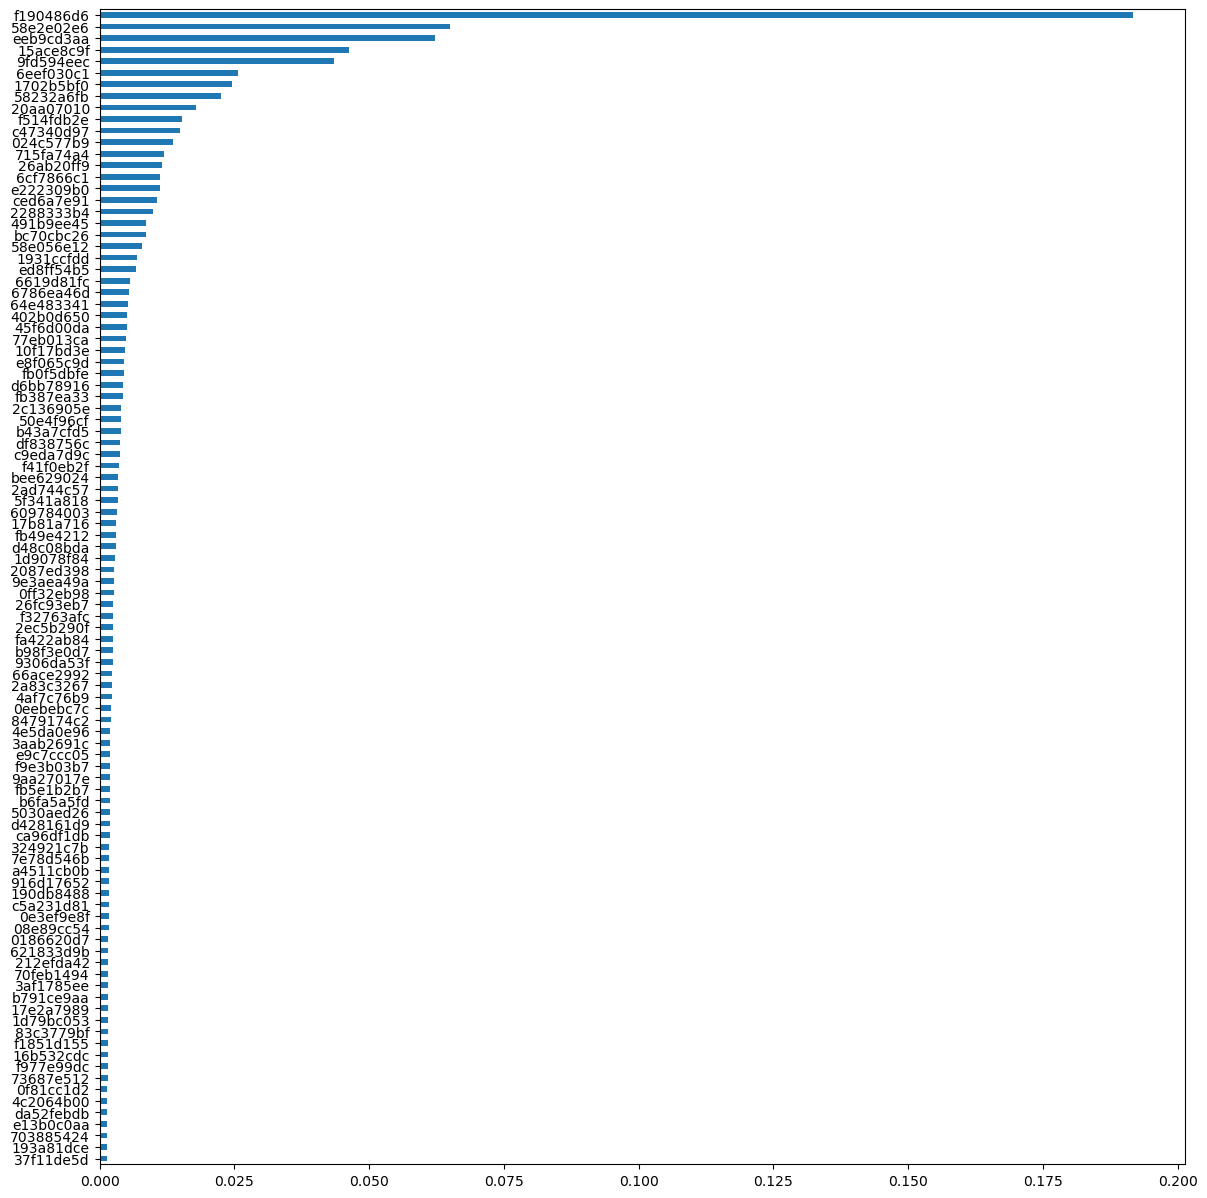

In [74]:
# GradientBoostingRegressor feature importance - top 100
feat_importances = pd.Series(clf_gb.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.nlargest(100)
plt.figure(figsize=(14,15))
feat_importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

The above plot looks very cluttered. Instead, we will take a look at the top 25 features.

In [76]:
print(pd.Series(clf_gb.feature_importances_, index=X_train.columns).nlargest(10))

f190486d6    0.191684
58e2e02e6    0.064993
eeb9cd3aa    0.062291
15ace8c9f    0.046292
9fd594eec    0.043513
6eef030c1    0.025690
1702b5bf0    0.024469
58232a6fb    0.022472
20aa07010    0.017970
f514fdb2e    0.015200
dtype: float64


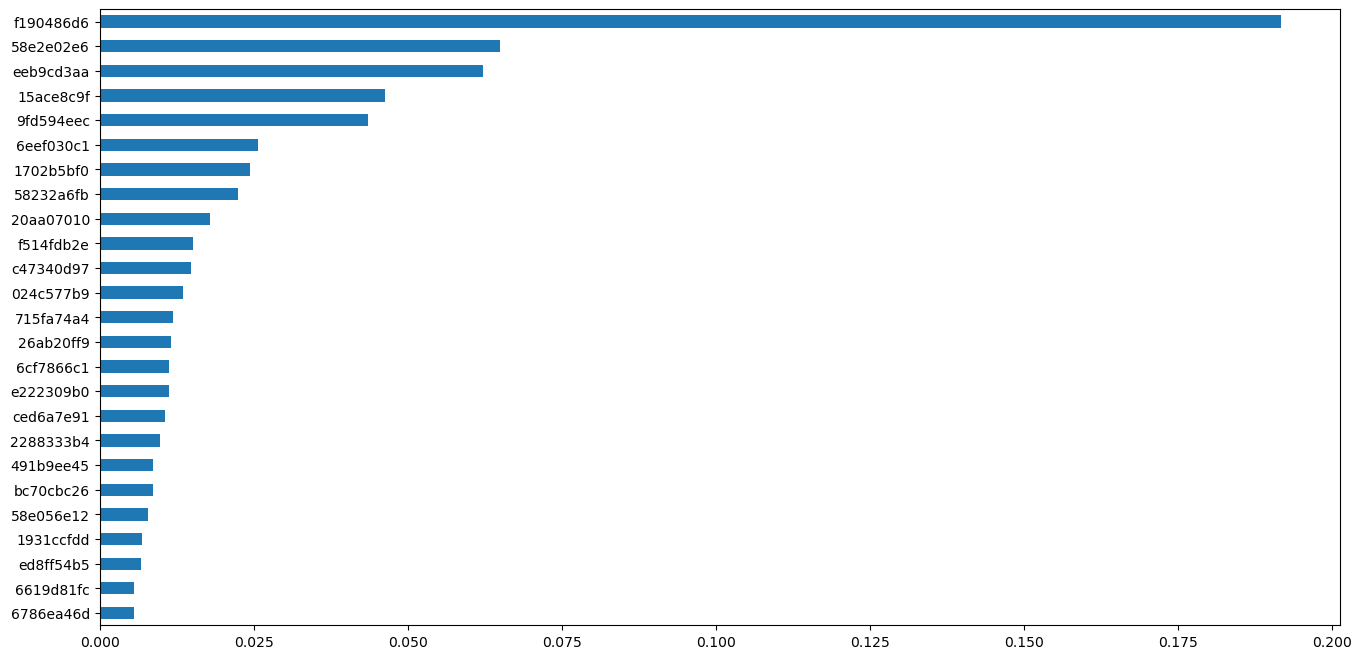

In [77]:
# GradientBoostingRegressor feature importance - top 25
feat_importances_gb = pd.Series(clf_gb.feature_importances_, index=X_train.columns)
feat_importances_gb = feat_importances_gb.nlargest(25)
plt.figure(figsize=(16,8))
feat_importances_gb.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

The top 10 features with their feature importances.

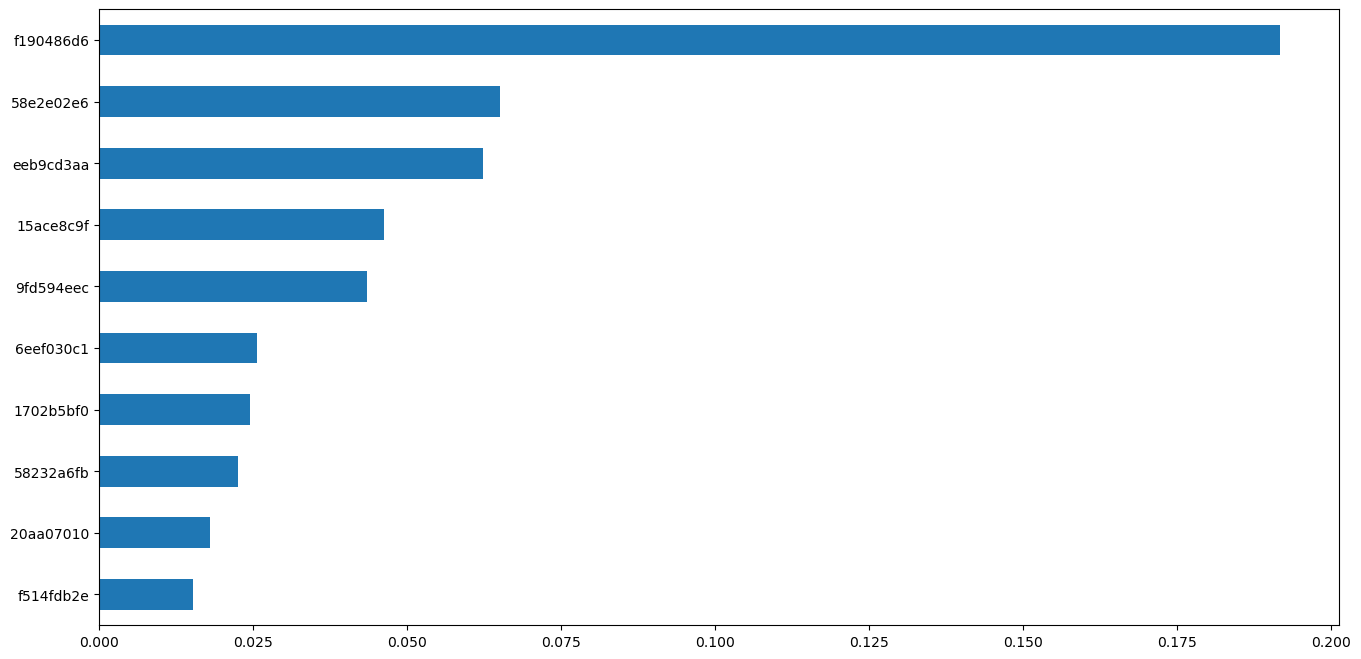

In [53]:
# GradienBootstingRegressor Feature Importance - top 10
feat_importances = pd.Series(clf_gb.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.nlargest(10)
plt.figure(figsize=(16,8))
feat_importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

In [55]:
print(pd.Series(clf_gb.feature_importances_, index=X_train.columns).nlargest(10))

f190486d6    0.191684
58e2e02e6    0.064993
eeb9cd3aa    0.062291
15ace8c9f    0.046292
9fd594eec    0.043513
6eef030c1    0.025690
1702b5bf0    0.024469
58232a6fb    0.022472
20aa07010    0.017970
f514fdb2e    0.015200
dtype: float64


##### Feature Importance from RandomForestRegressor

In [78]:
# Find feature importance
clf_rf = RandomForestRegressor(random_state = 42)
clf_rf.fit(X_train, y_train)
print(clf_rf)

RandomForestRegressor(random_state=42)


We will plot the top 25 features from RandomForestRegressor to see how similar they are with the top features given by GradientBoostingRegressor.

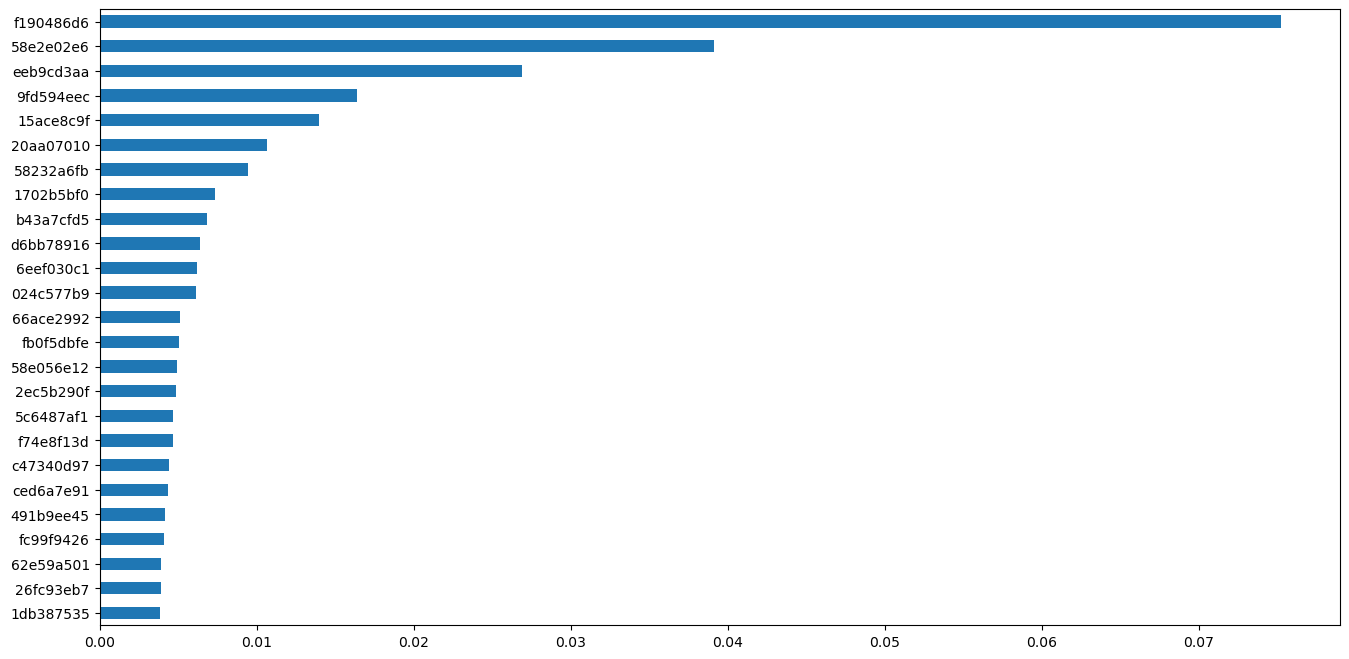

In [79]:
# RandomForestRegressor feature importance - top 25
feat_importances_rf = pd.Series(clf_rf.feature_importances_, index=X_train.columns)
feat_importances_rf = feat_importances_rf.nlargest(25)
plt.figure(figsize=(16,8))
feat_importances_rf.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

In [80]:
print(pd.Series(clf_rf.feature_importances_, index=X_train.columns).nlargest(10))

f190486d6    0.075227
58e2e02e6    0.039116
eeb9cd3aa    0.026895
9fd594eec    0.016386
15ace8c9f    0.013971
20aa07010    0.010676
58232a6fb    0.009450
1702b5bf0    0.007336
b43a7cfd5    0.006869
d6bb78916    0.006410
dtype: float64


##### GradientBoostingRegressor vs RandomForestRegressor Top 25 Features

<Figure size 640x480 with 0 Axes>

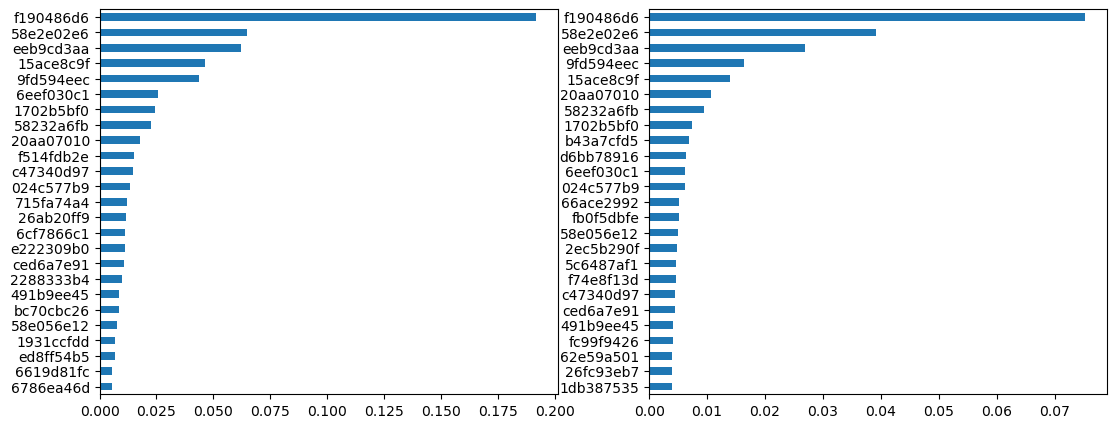

In [84]:
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(13,5))
feat_importances_gb.plot(kind='barh', ax=ax[0])
feat_importances_rf.plot(kind='barh', ax=ax[1])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.show()

In [85]:
s1 = pd.Series(clf_gb.feature_importances_, index=X_train.columns).nlargest(10).index
s2 = pd.Series(clf_rf.feature_importances_, index=X_train.columns).nlargest(10).index

common_features = pd.Series(list(set(s1).intersection(set(s2)))).values

print(common_features)

['58e2e02e6' 'f190486d6' '58232a6fb' 'eeb9cd3aa' '15ace8c9f' '9fd594eec'
 '20aa07010' '1702b5bf0']


The common features between the two models are represented by the following column names:

[ '58e2e02e6'
'f190486d6'
'58232a6fb'
'eeb9cd3aa'
'15ace8c9f'
'9fd594eec'
'20aa07010'
'1702b5bf0'].
These features are considered highly important by both the Gradient Boosting and Random Forest models, which suggests that they have a significant impact on the predictive performance of both models. You can further investigate these common features to gain insights into what aspects of the data are most influential in making predictions.

### Data Visualization

Below We will see some visualizations related to the top features.

/var/folders/kz/h8tq975x2157t01n92bx67zw0000gn/T/ipykernel_74055/2839271669.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['target'] = y_train
/Users/sangth/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/sangth/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/sangth/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Users/sangth/opt/anaconda3

Text(0.5, 0.98, 'Paitplot of Top 6 Important Feature')

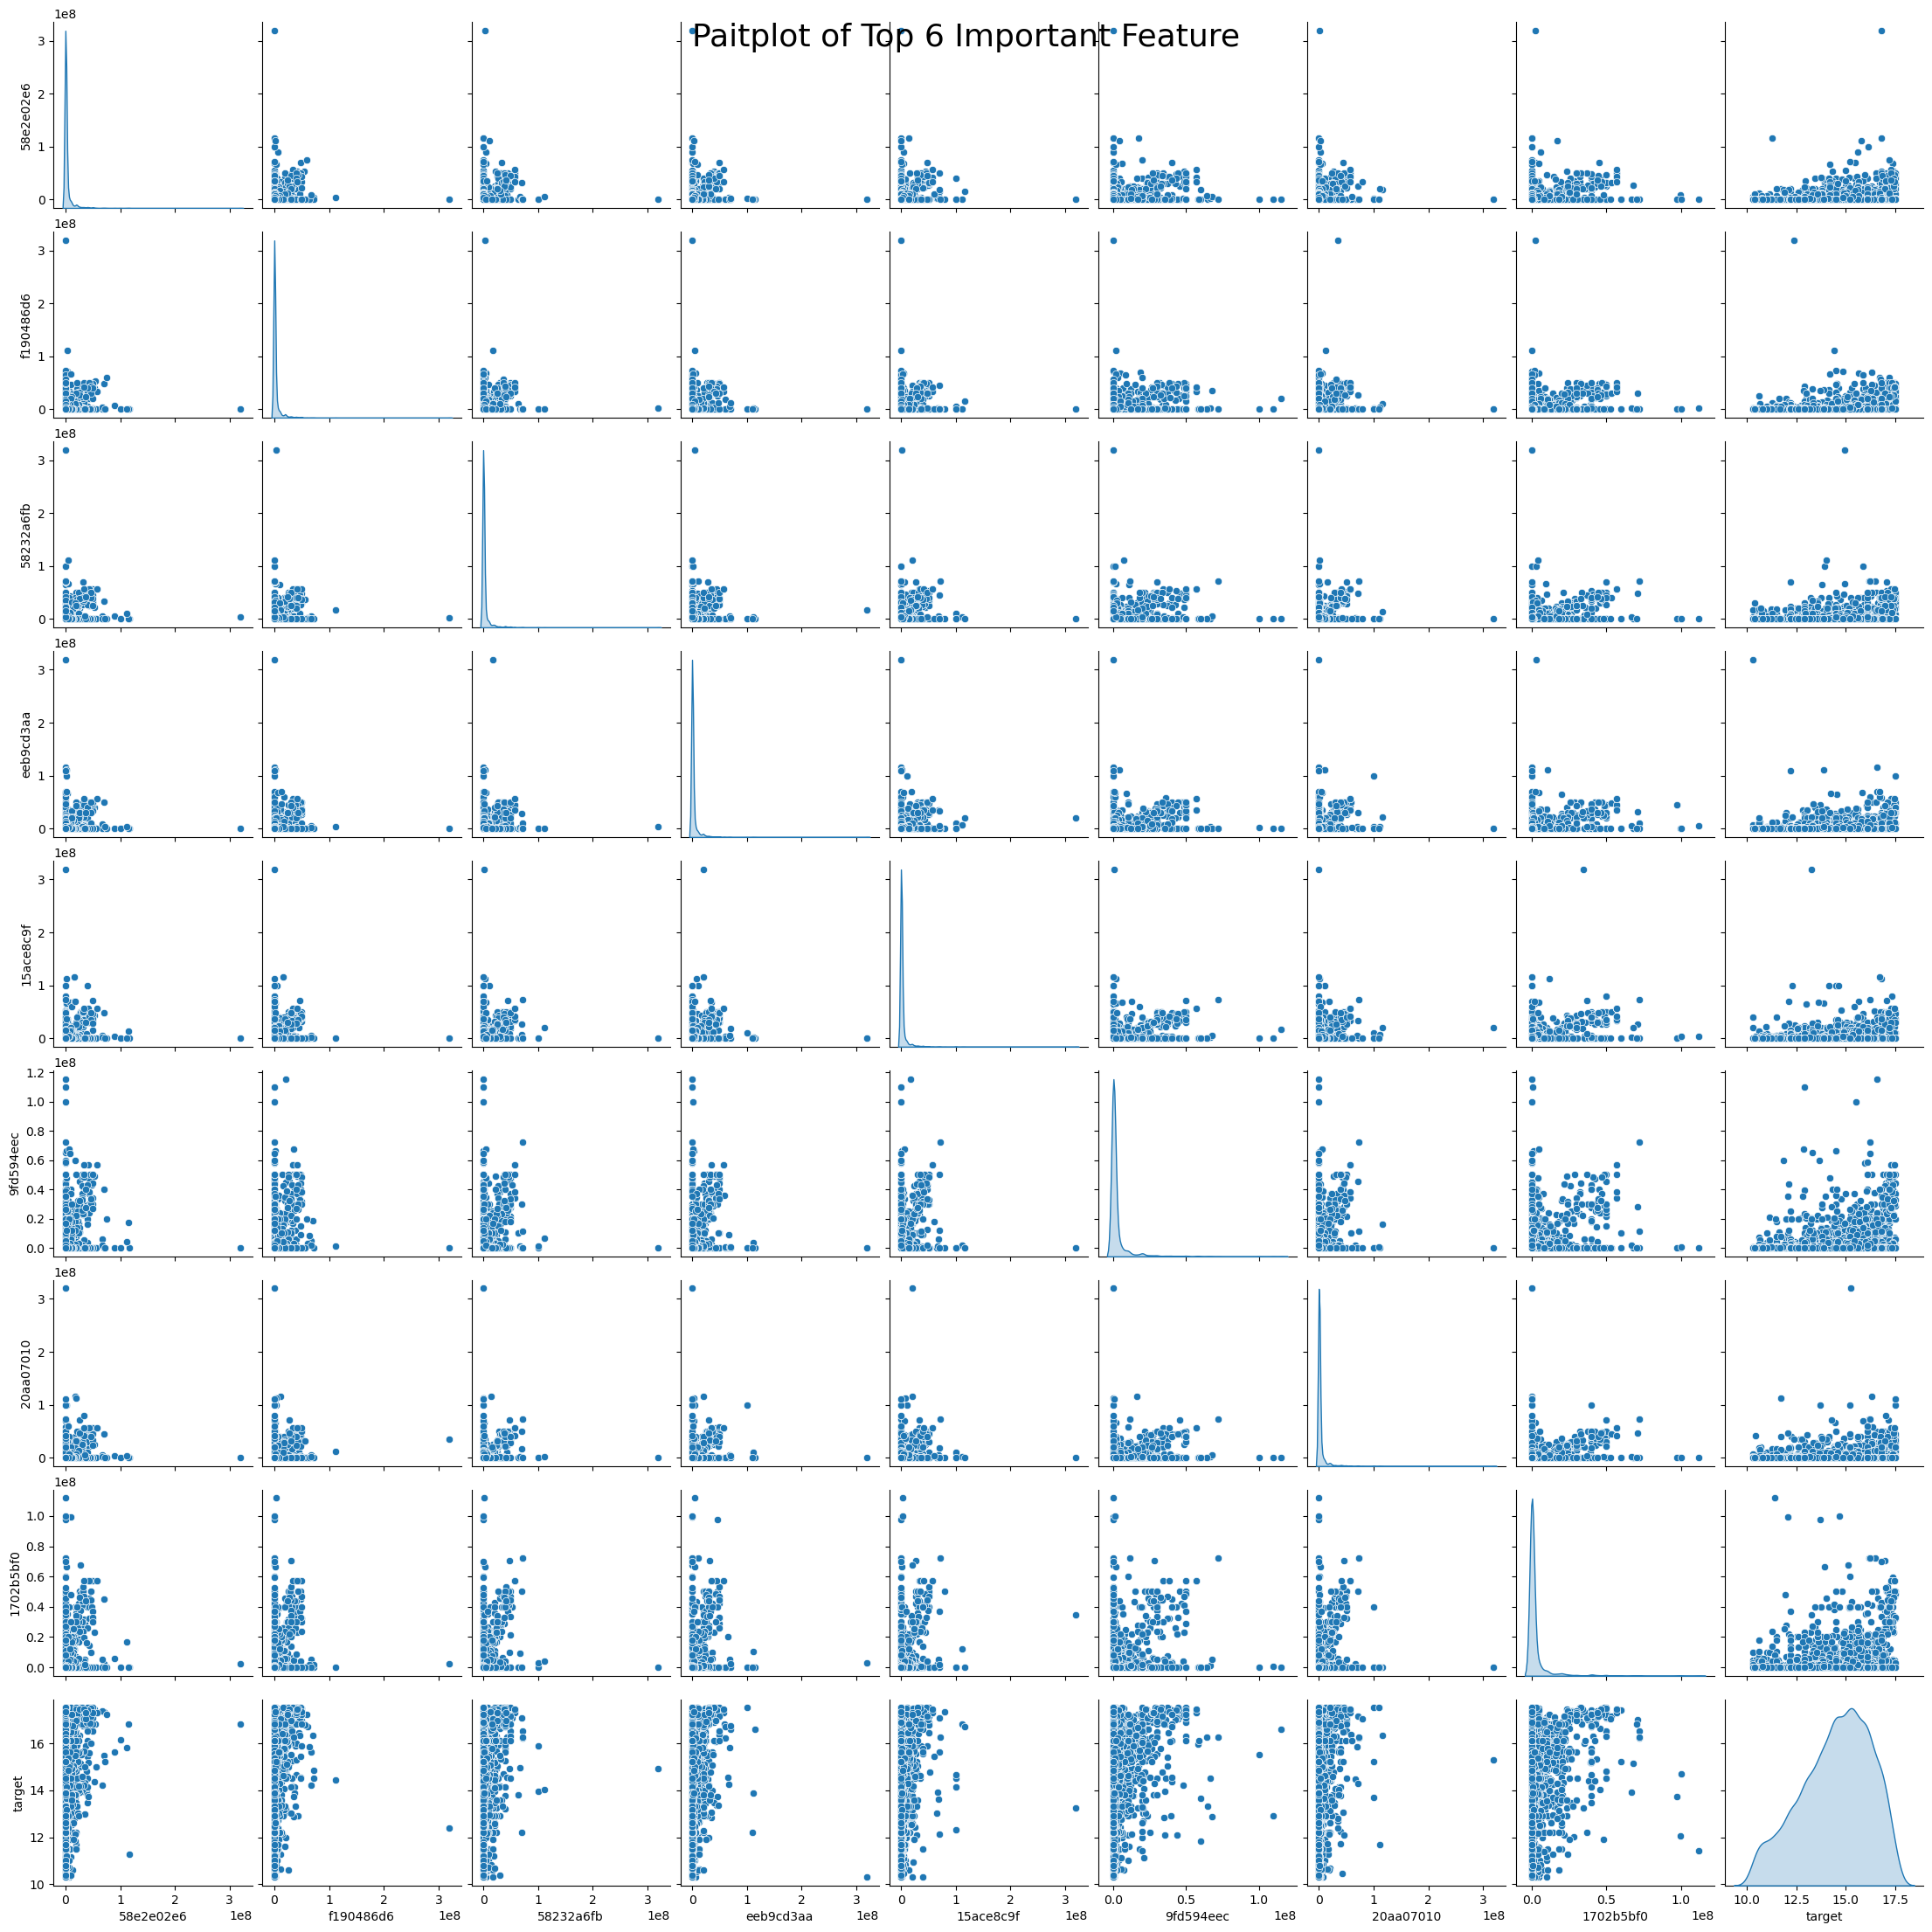

In [86]:
df_plot = X_train[['58e2e02e6', 'f190486d6', '58232a6fb', 'eeb9cd3aa', '15ace8c9f', '9fd594eec',
 '20aa07010', '1702b5bf0']]
df_plot['target'] = y_train

g = sns.pairplot(df_plot, diag_kind='kde', palette='BuGn_r')
g.fig.suptitle('Paitplot of Top 6 Important Feature', fontsize=26)

### Correlation HeatMap

In [87]:
# PLot Correlation HeatMap for top 20 features from GB and RF Models
s1 = pd.Series(clf_gb.feature_importances_, index=X_train.columns).nlargest(20).index
s2 = pd.Series(clf_rf.feature_importances_, index=X_train.columns).nlargest(20).index

common_features = pd.Series(list(set(s1).union(set(s2)))).values

print(common_features)

['024c577b9' '58e2e02e6' 'f514fdb2e' '715fa74a4' '66ace2992' '58232a6fb'
 'c47340d97' '5c6487af1' '1702b5bf0' '15ace8c9f' 'e222309b0' '2ec5b290f'
 'f74e8f13d' '6eef030c1' '6cf7866c1' '2288333b4' 'eeb9cd3aa' 'd6bb78916'
 '26ab20ff9' '58e056e12' 'f190486d6' '20aa07010' 'ced6a7e91' 'b43a7cfd5'
 'bc70cbc26' '491b9ee45' '9fd594eec' 'fb0f5dbfe']


/var/folders/kz/h8tq975x2157t01n92bx67zw0000gn/T/ipykernel_74055/663889277.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


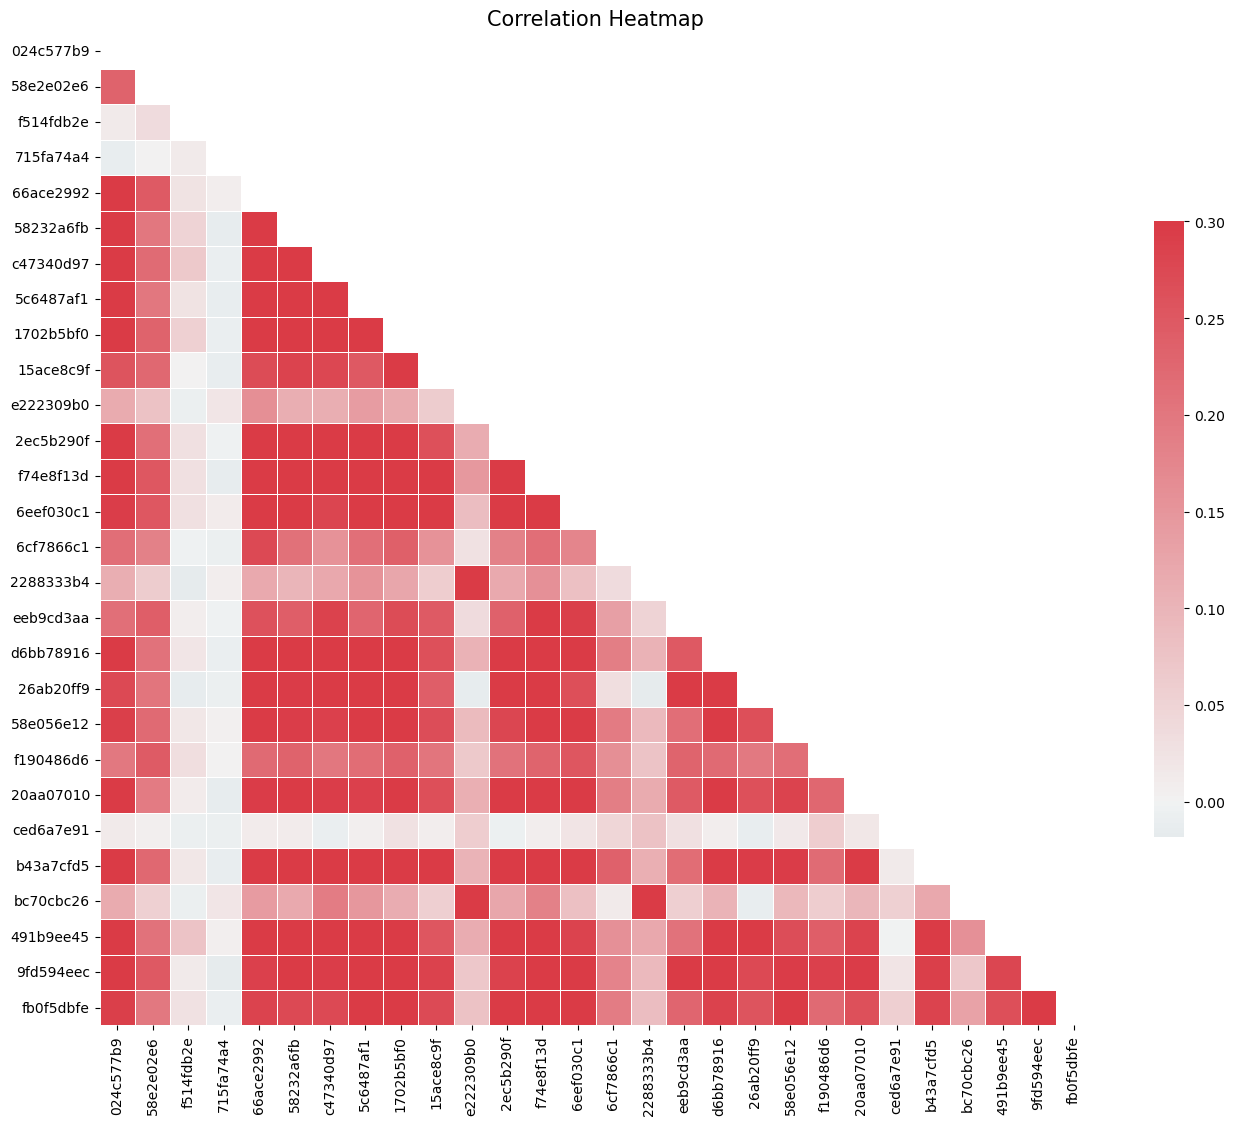

In [91]:
df_plot = pd.DataFrame(X_train, columns = common_features)
corr = df_plot.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib Figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation Heatmap", fontsize = 15)
plt.show()